# Import and loading

In [31]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import Evaluator

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import prince
import numpy as np

In [32]:
data = Loader.load_by_fueltype("Combustion")
label_encoder = LabelEncoder()

c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[co

# Functions

In [33]:
def drop_columns_full_nan(data: pd.DataFrame) -> pd.DataFrame:
    #Remove the column that only contain NAs
    cols_to_drop = data.columns[data.isna().all()]
    data = data.drop(cols_to_drop, axis=1)
    return data

def get_combustion_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])

    #if all the values of the numerical columns is 0, we rem['Combustion']ove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)
    return numerical_columns

def fill_combustion_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    cols_mode = ['displacement_liters','doors','seatingCapacity','number_of_cylinders','cubicCapacity',"dimensions.length","dimensions.height","Llantas_Diametro_cm","number_of_cylinders","bore_diameter","stroke_length"]
    #fill the elemental columns that has a minor amount of missing data with the mode
    for col in cols_mode:
        numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, col)

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="rpm_max_torque")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="rpm_max_power")
    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_combustion_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Select and print only the categorical columns
    ret = df.select_dtypes(include=['category'])
    
    # Temporarily convert the column to strings to perform the replacement
    ret['traction'] = ret['traction'].astype(str).replace({"trasera": "trasero", "delantera": "delantero"})
    # Convert back to a categorical type
    ret['traction'] = ret['traction'].astype('category')

    
    # Remove redundant columns if this function is defined
    ret = Data_processor.remove_redundand_columns(ret)
    return ret


def fill_combustion_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    mode_cols = ['brakes','version','jato_classification']
    for col in mode_cols:
        df = Data_processor.fill_na_with_mode(df, col)
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model"] , Y="environmentalLabel")
    return df

def category_convert(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_convert = df.select_dtypes(include=['object']).columns
    for col in cols_to_convert:
        df[col] = df[col].astype('category')
    return df


# Column filters

In [34]:
# Quit all electric columns from data['Combustion']
for column in data.columns:
    if column.startswith('electric'):
        data = data.drop(columns=column)
pd.set_option('display.max_rows', None)

In [35]:
# convert object columns to category
data = category_convert(data)

categorical_columns = get_combustion_categorical_columns(data)

categorical_columns = fill_combustion_categorical_columns(categorical_columns)

# Check amount of missing values
missing_values = categorical_columns.isnull().sum()
missing_values = missing_values[missing_values > 0]

print(missing_values)
categorical_columns.head()
categorical_columns.columns
#categorical_columns['traction']

Series([], dtype: int64)


Index(['color', 'brand', 'model', 'version', 'fuelType', 'bodyTypeId',
       'transmissionTypeId', 'province', 'environmentalLabel',
       'jato_classification', 'traction', 'brakes', 'front_suspension',
       'rear_suspension', 'Acabado Exterior_Alerón',
       'Acabado Exterior_Cristales', 'Acabado Exterior_Faldones',
       'Acabado Exterior_Pintura', 'Acabado Exterior_Rueda', 'AC_Zones',
       'AC_Type', 'Metodo_Apertura', 'Tipo_Faro', 'interior_clock',
       'arm_suppport_front', 'arm_suppport_back', 'price_categ'],
      dtype='object')

In [36]:
# Drop all na columns 
data = drop_columns_full_nan(data)

numerical_columns = get_combustion_numerical_columns(data)


# fill the missing data in numerical columns
numerical_columns = fill_combustion_numerical_columns(numerical_columns)

# Check amount of missing values
missing_values_num = numerical_columns.isnull().sum()
missing_values_num = missing_values_num[missing_values_num > 0]

data[numerical_columns.columns] = numerical_columns

#correlation_matrix = numerical_columns.corr()
#correlation_matrix = correlation_matrix.sort_values(by='price', ascending=False)
print(missing_values_num)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.6154091221985554%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 17.70914536272189%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 6.410215656255401%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 7.903819131160218%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 6.824540773438649%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 2.55180902596012e+16%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> rpm_max_torque: 67.97560330482807%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> rpm_max_power: 20.028480167086347%
Series([], dtype: int64)


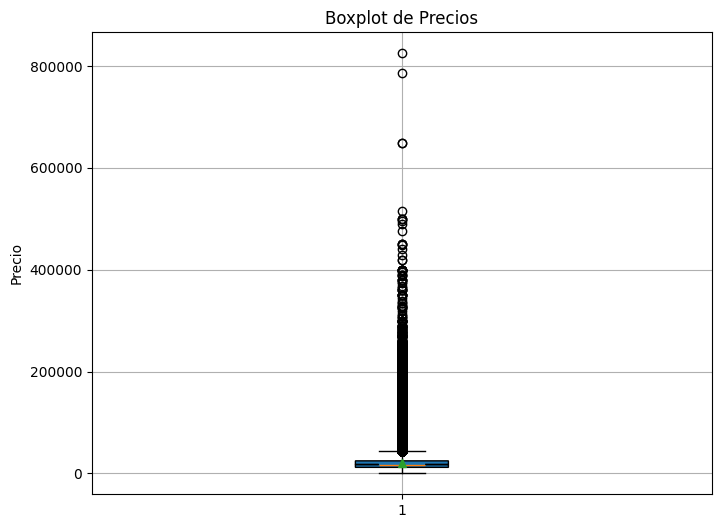

In [37]:
precios_combustion = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_combustion, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

Even though there seems to be many outliers in the data, after a manual inspection, it was found that the data is correct and the outliers are valid data points. (Most of them are from luxury brands such as Lamborghini, Ferrari, etc.)

In [38]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)[:10]

43901.5


,price,brand
idx,,
48458,825000,MERCEDES-BENZ
38166,786500,FERRARI
16685,648500,FERRARI
18873,648500,FERRARI
119510,515000,PORSCHE
16086,499900,FERRARI
78396,499900,LAMBORGHINI
76218,499900,LAMBORGHINI
19151,495000,LAMBORGHINI


# PCA

In [39]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

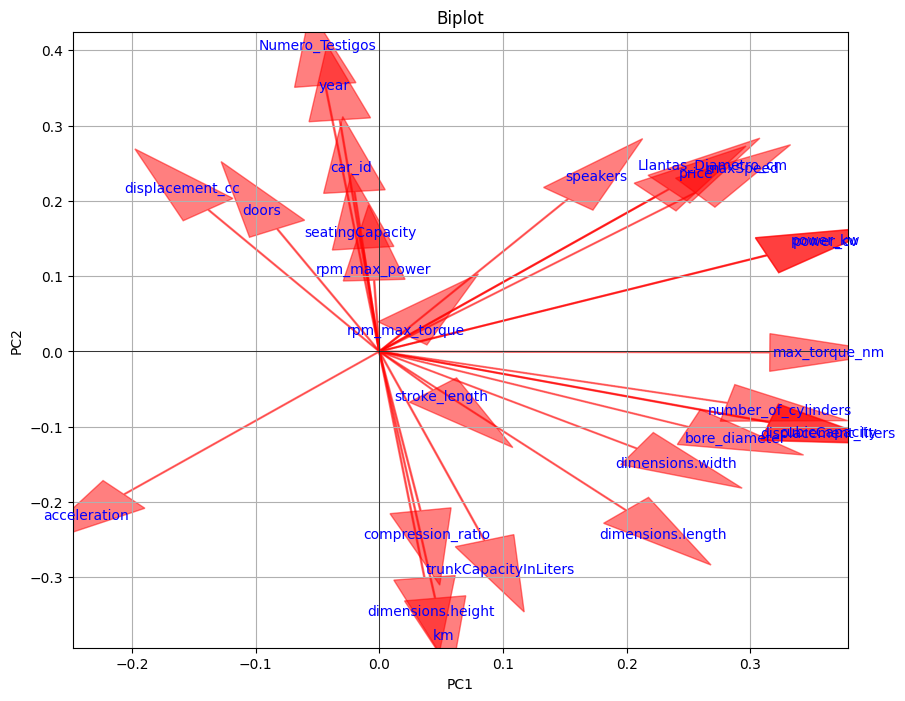

In [40]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

# Test CART regression trees with only numerical variables

In [41]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

MAE: 2275.2995339521353 
 MSE: 57882217.11892269 
 RMSE: 7608.036351051609 
 R2: 0.8693807758805843 
 MAPE: 12.033195862303094
Mean: 2275.2995339521353
Variance: 52705229.14971987
Standard Deviation: 7259.836716464074


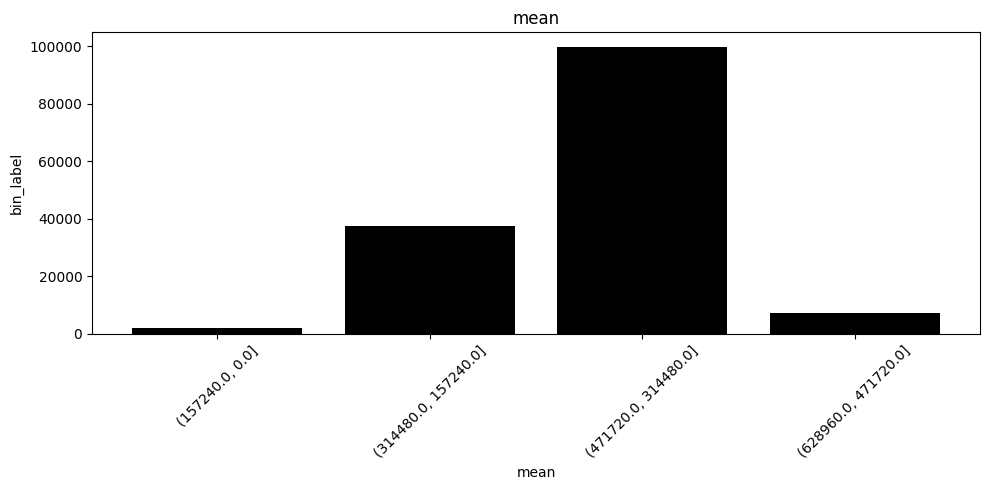

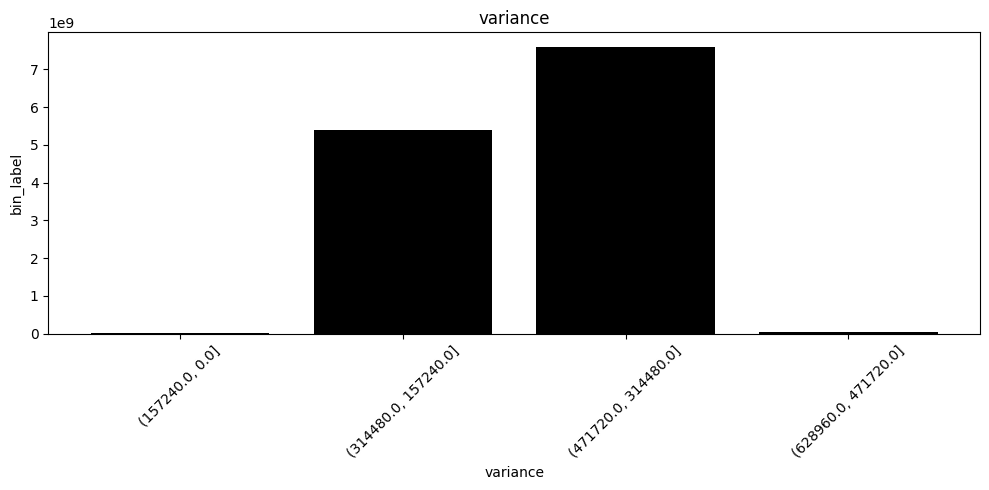

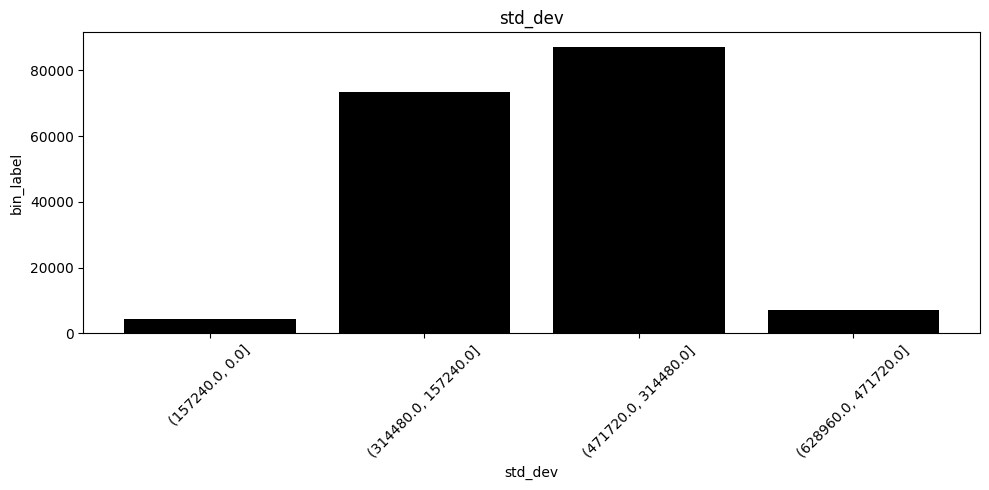

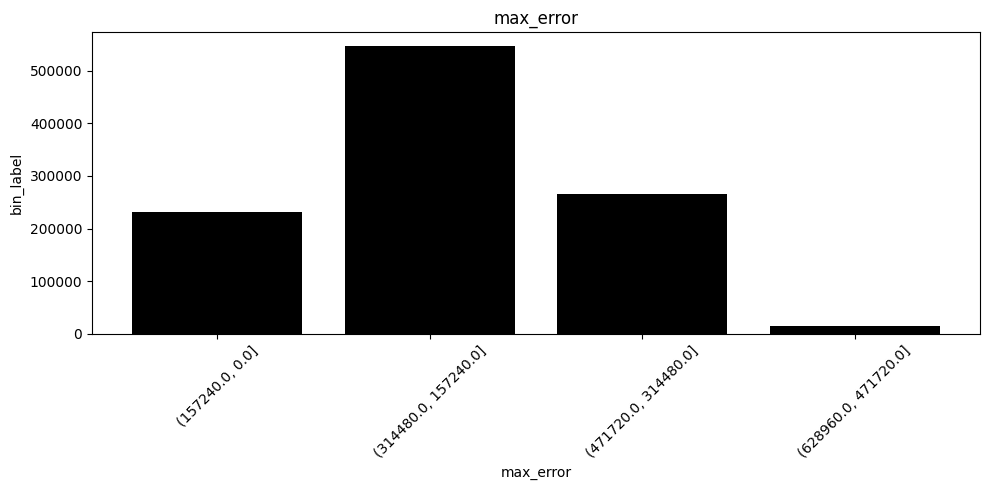

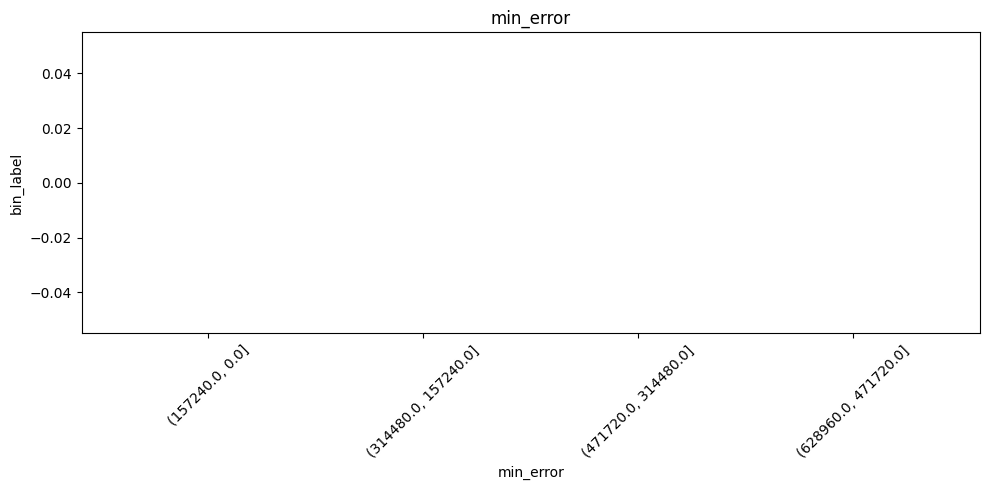

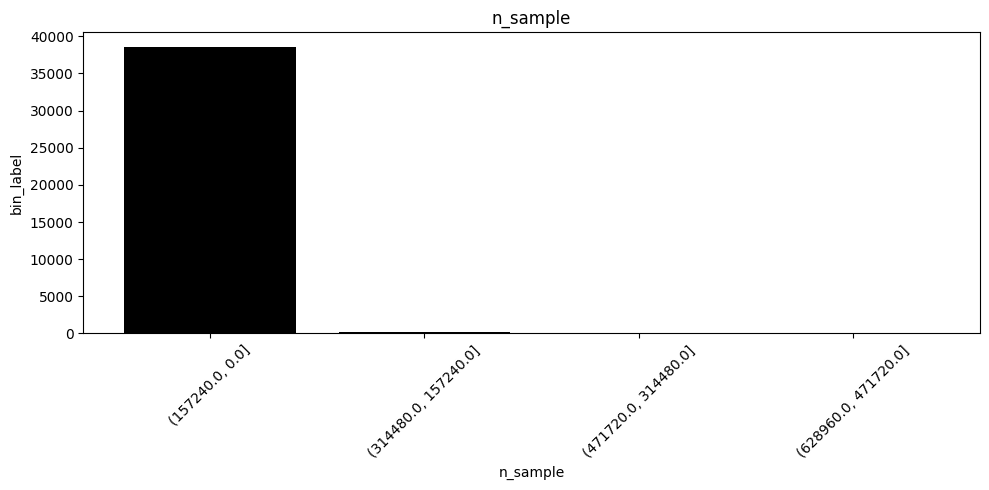

,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(157240.0, 0.0]",2094.337242,1.950047e+07,4415.933474,230900.0,0.0,38597
1,"(314480.0, 157240.0]",37416.195804,5.385735e+09,73387.568079,546500.0,0.0,143
2,"(471720.0, 314480.0]",99775.500000,7.600990e+09,87183.656122,266000.0,0.0,20
3,"(628960.0, 471720.0]",7000.000000,4.900000e+07,7000.000000,14000.0,0.0,2


In [42]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

Evaluator.eval_regression(y_pred, y_test)

# CA

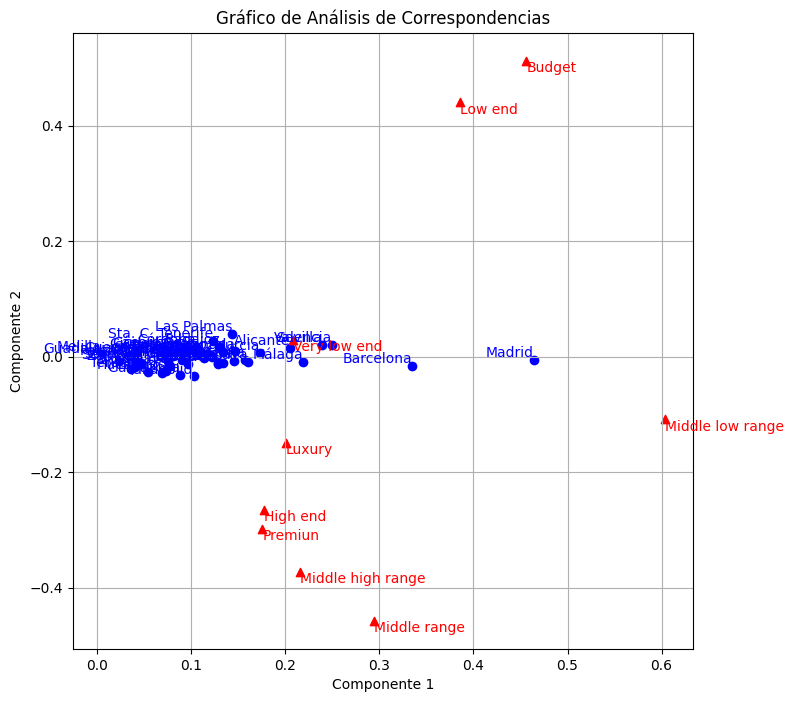

In [43]:
Data_processor.CA(categorical_columns=categorical_columns, col_x="province", col_y="price_categ")

In [44]:
categorical_columns["price_categ"].value_counts()

price_categ
Middle low range     47015
Budget               26867
Low end              19272
Middle range         11219
Middle high range     6014
Very low end          5609
Luxury                5182
High end              4049
Premiun               3977
Name: count, dtype: int64

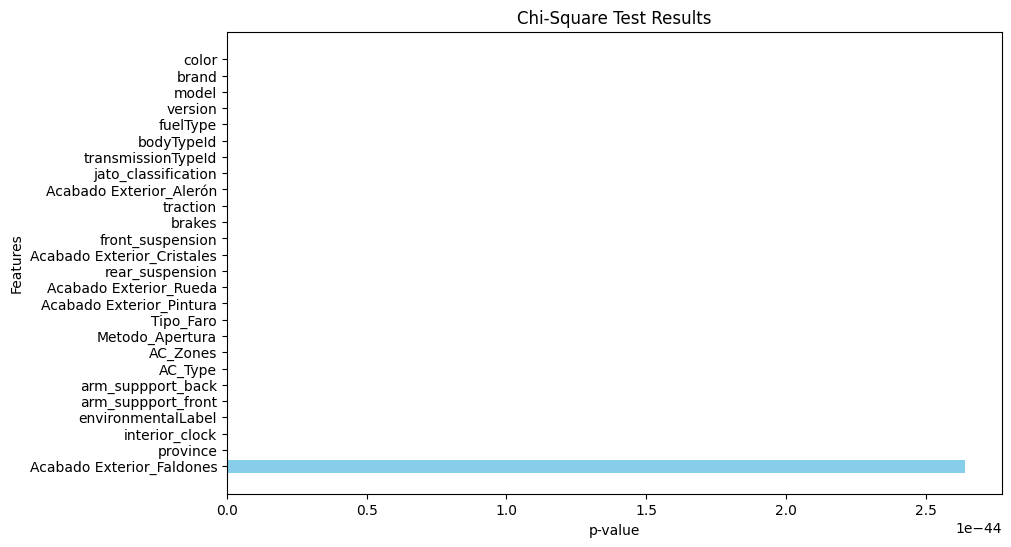

Index(['color', 'brand', 'model', 'version', 'fuelType', 'bodyTypeId',
       'transmissionTypeId', 'jato_classification', 'Acabado Exterior_Alerón',
       'traction', 'brakes', 'front_suspension', 'Acabado Exterior_Cristales',
       'rear_suspension', 'Acabado Exterior_Rueda', 'Acabado Exterior_Pintura',
       'Tipo_Faro', 'Metodo_Apertura', 'AC_Zones', 'AC_Type',
       'arm_suppport_back', 'arm_suppport_front', 'price_categ'],
      dtype='object')

In [45]:
categorical_columns = Data_processor.chi_square_filter(categorical_columns, "price_categ", p_value_filter=0)
categorical_columns.columns

# Categorical

## Cart

In [46]:
columns = list(categorical_columns.columns)
columns.remove("price_categ")
for col in columns:
    categorical_columns[col] = label_encoder.fit_transform(categorical_columns[col])

# Preparar los datos
X = categorical_columns.drop(columns=["price_categ"])
Y = categorical_columns["price_categ"].apply(lambda x: Loader.encode_price_categ(x))

# Dividir los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Crear el modelo de árbol de decisión
tree_model = DecisionTreeClassifier(random_state=42, criterion = "entropy")

# Entrenar el modelo
tree_model.fit(X_train, Y_train)

# Predecir las etiquetas del conjunto de prueba
Y_pred = tree_model.predict(X_test)

In [47]:
result = pd.DataFrame({"Real_Categorie": Y_test, "Prediction": Y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result.head()

,Real_Categorie,Prediction,diff
79111,Middle low range,Low end,1
25265,Low end,Low end,0
93565,Low end,Middle low range,1
92142,Budget,Middle range,1
122565,Premiun,Premiun,0


In [48]:
Evaluator.eval_classfication(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.700944223724266 
 Precision: 0.6992945791218039 
 Recall: 0.700944223724266 
 F1 Score: 0.7000273573641185
Confusion Matrix:
 [[11503    48   154     5   130  1491   741    24     9]
 [   55   516     2    35   294     5   136   172     0]
 [  147     2  4018     1     5  1075    10     0   524]
 [   11    48     1  1270    28     3    14   179     0]
 [  188   240     1    18   815    12   451    78     1]
 [ 1311     5  1247     0     9  5428    25     7    28]
 [ 1043    91     9    11   322    27  1819    42     2]
 [   30   214     4   148    89     4    45   659     0]
 [   10     2   479     0     0    47     3     0  1142]]


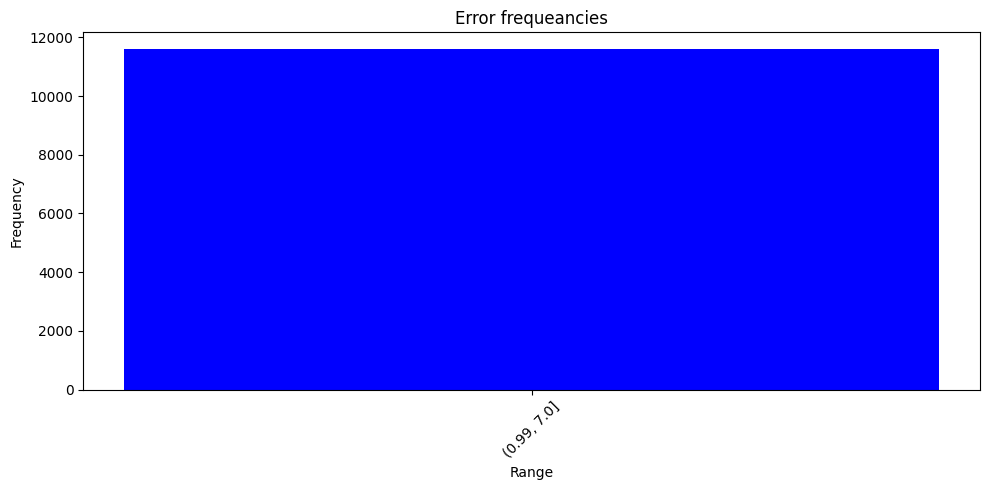

Errors: {'(0.99, 7.0]': 11592}
Error mean: 1.19824016563147
Error rate: 29.9055776275734 %
Overall mean: 0.3583406428976833


In [49]:
Evaluator.eval_ordinal_classification (result["diff"])

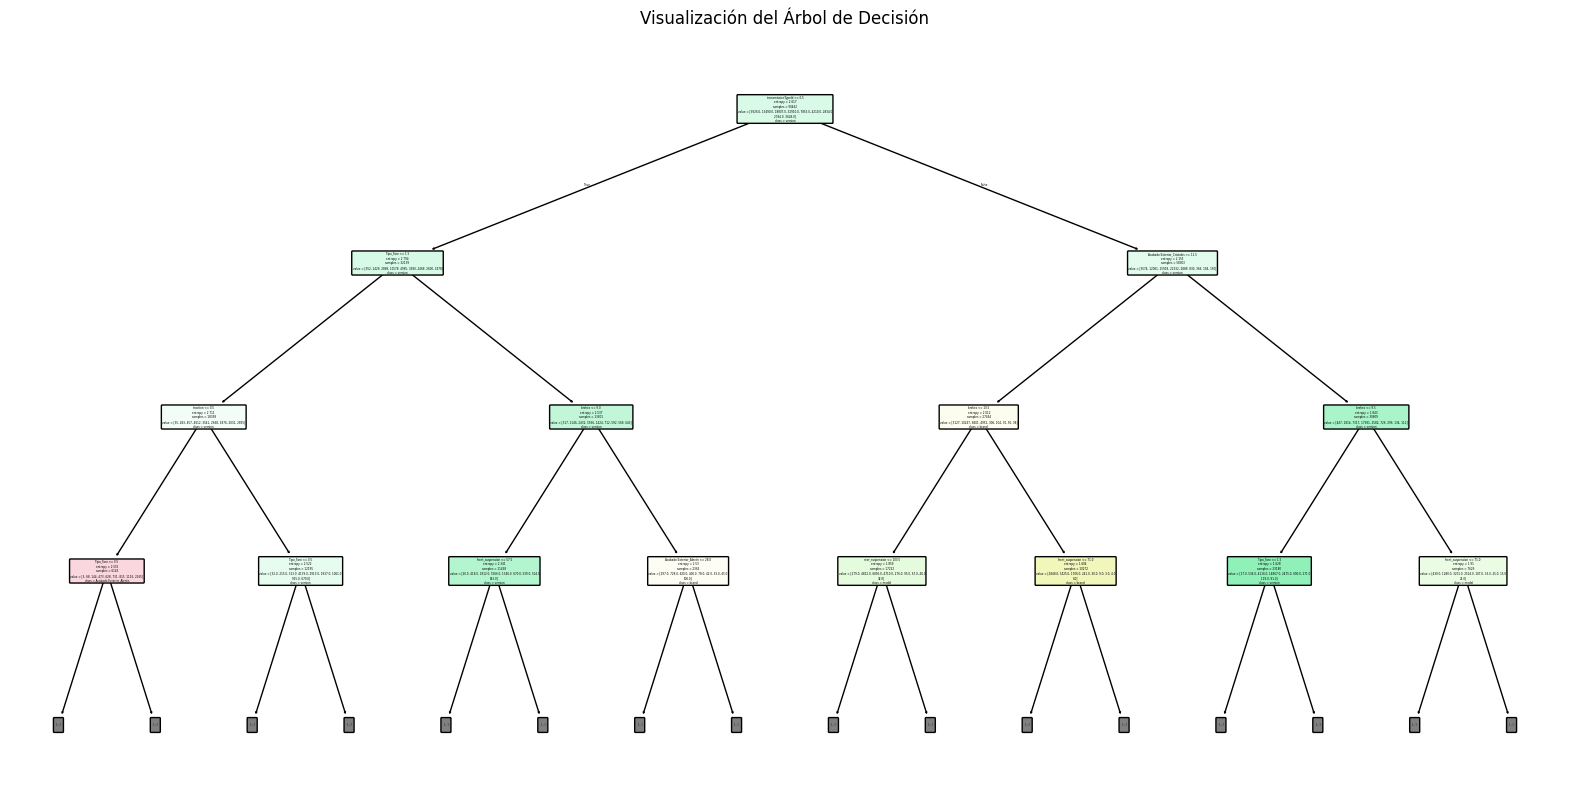

In [50]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()

## Random Forest

In [51]:
columns = list(categorical_columns.columns)
columns.remove("price_categ")
for col in columns:
    categorical_columns[col] = label_encoder.fit_transform(categorical_columns[col])

# Preparar los datos
X = categorical_columns.drop(columns=["price_categ"])
Y = categorical_columns["price_categ"].apply(lambda x: Loader.encode_price_categ(x))

# Dividir los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Crear el modelo de árbol de decisión
tree_model = RandomForestClassifier(random_state=42, criterion = "entropy")

# Entrenar el modelo
tree_model.fit(X_train, Y_train)

# Predecir las etiquetas del conjunto de prueba
Y_pred = tree_model.predict(X_test)

In [52]:
result = pd.DataFrame({"Real_Categorie": Y_test, "Prediction": Y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result.head()

,Real_Categorie,Prediction,diff
79111,Middle low range,Low end,1
25265,Low end,Low end,0
93565,Low end,Middle low range,1
92142,Budget,Middle range,1
122565,Premiun,Premiun,0


In [53]:
Evaluator.eval_classfication(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.7252463753160312 
 Precision: 0.7218639852728725 
 Recall: 0.7252463753160312 
 F1 Score: 0.7233275218508313
Confusion Matrix:
 [[11866    25    80     6   106  1262   740    15     5]
 [   54   537     1    33   273     2   113   202     0]
 [  120     0  4197     0     1  1038     6     0   420]
 [    8    41     2  1324    20     0     4   155     0]
 [  181   250     1    17   828     7   434    85     1]
 [ 1401     0  1035     0     3  5600    10     3     8]
 [  997    82     5    12   338    17  1877    37     1]
 [   32   176     4   172    75     4    38   692     0]
 [    3     1   457     0     0    29     2     0  1191]]


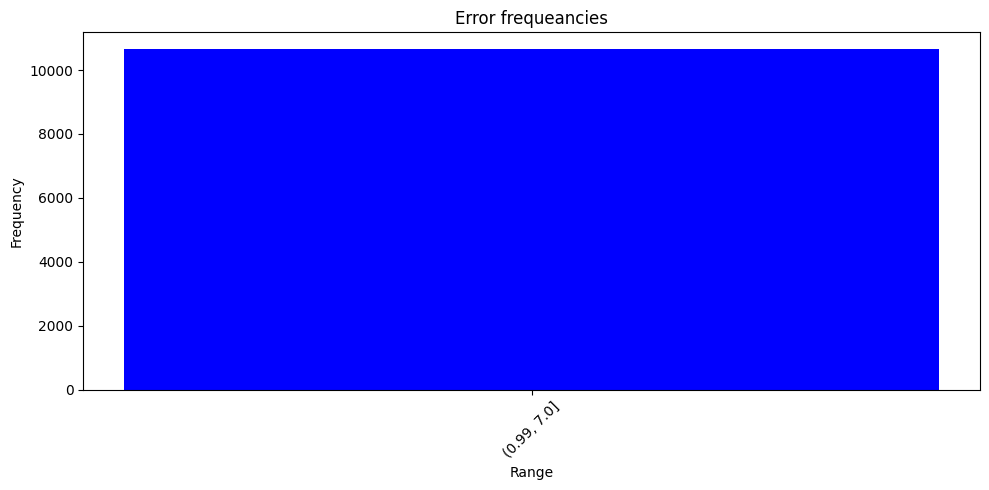

Errors: {'(0.99, 7.0]': 10650}
Error mean: 1.1651643192488264
Error rate: 27.475362468396884 %
Overall mean: 0.32013312006604405


In [54]:
Evaluator.eval_ordinal_classification (result["diff"])

In [55]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Prepare the data
X = categorical_columns.drop(columns=["price_categ"])
Y = categorical_columns["price_categ"].apply(lambda x: Loader.encode_price_categ(x))

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Create the Naive Bayes model
nb_model = GaussianNB() # You can try other Naive Bayes models such as ComplementNB, BernoulliNB, BinomialNB but Gaussian gives the best results in this case

# Train the model
nb_model.fit(X_train, Y_train)

# Predict the labels of the test set
Y_pred = nb_model.predict(X_test)

# Create a results DataFrame to compare predictions
result = pd.DataFrame({"Real_Categorie": Y_test, "Prediction": Y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)

# Show the first few rows of the results
result.head()


,Real_Categorie,Prediction,diff
79111,Middle low range,Low end,1
25265,Low end,Low end,0
93565,Low end,Middle low range,1
92142,Budget,Budget,0
122565,Premiun,Middle high range,2


In [56]:
Evaluator.eval_classfication(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.4502863629327692 
 Precision: 0.45622352491934 
 Recall: 0.4502863629327692 
 F1 Score: 0.44749074061762023
Confusion Matrix:
 [[7649  123  761  214  192 3184  940  841  201]
 [ 247   24   16  150  154   20  118  483    3]
 [ 544   21 2584   32    4 1628  155   67  747]
 [  91    6    7  936   31    4   99  377    3]
 [ 539   34   27  169  237   67  315  408    8]
 [1972   56 1459   51    9 3928  141  169  275]
 [1488   52   67  144  203  208  613  571   20]
 [ 133   16   14  258   82    9  123  551    7]
 [  81    4  479   11    1  141   30    4  932]]


In [57]:
#from sklearn.svm import SVC
#from sklearn.model_selection import train_test_split
#import numpy as np
#import pandas as pd
#
## Preprocess categorical columns
#columns = list(categorical_columns.columns)
#columns.remove("price_categ")
#for col in columns:
#    categorical_columns[col] = label_encoder.fit_transform(categorical_columns[col])
#
## Prepare the data
#X = categorical_columns.drop(columns=["price_categ"])
#Y = categorical_columns["price_categ"].apply(lambda x: Loader.encode_price_categ(x))
#
## Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
#
## Create the SVM model with specified kernel
#svm_model = SVC(kernel="linear", random_state=42)
#
## Train the model
#svm_model.fit(X_train, Y_train)
#
## Predict the labels of the test set
#Y_pred = svm_model.predict(X_test)
#
## Create a results DataFrame to compare predictions
#result = pd.DataFrame({"Real_Categorie": Y_test, "Prediction": Y_pred})
#result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
#result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
#result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
#
## Show the first few rows of the results
#result.head()


## 